<a href="https://colab.research.google.com/github/Mahdi-Kriaa/food_sales_prediction/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate

# Importing Data

In [ ]:
file_id = "1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw"

In [ ]:
df_sales = pd.read_csv(f"https://docs.google.com/uc?id={file_id}")

# Cleaning Data

In [ ]:
df_sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
#number of rows and columns
df_sales.shape

(8523, 12)

In [ ]:
#datatypes of each variable
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
#checking if are there duplicates
df_sales.duplicated().any()

False

There is no duplicates in the data set

In [ ]:
#number of missing values for each variable
number_of_missing_values = df_sales.isna().sum()
number_of_missing_values

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
df_grouped_by_items = df_sales.groupby("Item_Identifier").first()
df_grouped_by_stores = df_sales.groupby("Outlet_Identifier").first()

In [ ]:
list_items = df_grouped_by_items[df_grouped_by_items.Item_Weight.isna()].index.to_list()
print("Items that have missing weights values over all the dataset :",list_items)
print(f"Percentage compared with the all missing values : {df_sales[df_sales.Item_Identifier.isin(list_items)].shape[0]/number_of_missing_values['Item_Weight']*100} %")
print(f"Percentage compared with the dataset size : {df_sales[df_sales.Item_Identifier.isin(list_items)].shape[0]/df_sales.shape[0]*100} %")

Items that have missing weights values over all the dataset : ['FDE52', 'FDK57', 'FDN52', 'FDQ60']
Percentage compared with the all missing values : 0.2734107997265892 %
Percentage compared with the dataset size : 0.04693183151472486 %


the percentage compared with the dataset size is not significant so we can drop raws that contain these items

In [ ]:
df_sales.drop(df_sales[df_sales.Item_Identifier.isin(list_items)].index,inplace=True)
df_sales.reset_index(drop=True,inplace=True)

In [ ]:
#replacing the other missing weight values
item_weights = df_sales.groupby("Item_Identifier").first().Item_Weight
for i in range(df_sales.shape[0]) :
  if df_sales.Item_Weight.isna()[i] :
    item = df_sales.loc[i,"Item_Identifier"]
    df_sales.loc[i,"Item_Weight"] = item_weights[item]

In [ ]:
list_stores = df_grouped_by_stores[df_grouped_by_stores.Outlet_Size.isna()].index.to_list()
print("Items that have missing weights values over all the dataset :",list_stores)
print(f"Percentage compared with the all missing values : {df_sales[df_sales.Outlet_Identifier.isin(list_stores)].shape[0]/number_of_missing_values['Outlet_Size']*100} %")
print(f"Percentage compared with the dataset size : {df_sales[df_sales.Outlet_Identifier.isin(list_stores)].shape[0]/df_sales.shape[0]*100} %")

Items that have missing weights values over all the dataset : ['OUT010', 'OUT017', 'OUT045']
Percentage compared with the all missing values : 100.0 %
Percentage compared with the dataset size : 28.2897053644794 %


The percentage compared with the dataset size is significant so we can't drop raws that contain missing values

<Axes: xlabel='Outlet_Size', ylabel='Outlet_Type'>

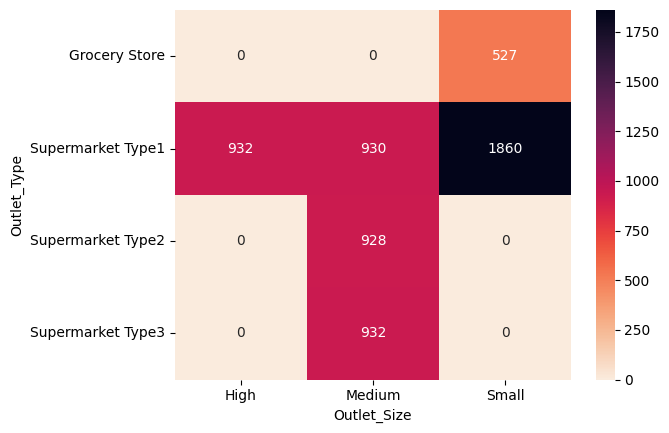

In [ ]:
contingency_table = pd.crosstab(df_sales['Outlet_Type'],df_sales['Outlet_Size'])
sns.heatmap(contingency_table, annot=True, fmt='d', cmap="rocket_r")

In [ ]:
#Identying types of stores with missing size values
df_sales[df_sales.Outlet_Identifier.isin(list_stores)].Outlet_Type.unique()

array(['Grocery Store', 'Supermarket Type1'], dtype=object)

We notice that grocery stores are all small and supermarkets type 1 are more likely to be small

In [ ]:
#replacing missing stores sizes
df_sales.Outlet_Size.fillna("Small",inplace=True)

In [ ]:
#checking that there are no missing values
df_sales.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
for c in ["Item_Fat_Content","Item_Type","Outlet_Size","Outlet_Location_Type"] :
  print(f"{c} elements : {df_sales[c].unique()}")

Item_Fat_Content elements : ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type elements : ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Size elements : ['Medium' 'Small' 'High']
Outlet_Location_Type elements : ['Tier 1' 'Tier 3' 'Tier 2']


In [ ]:
#fixing inconsistent categories of data
df_sales.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'},inplace=True)

In [ ]:
df_sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Data Exploration

array([[<Axes: title={'center': 'Item_Weight'}>,
        <Axes: title={'center': 'Item_Visibility'}>],
       [<Axes: title={'center': 'Item_MRP'}>,
        <Axes: title={'center': 'Outlet_Establishment_Year'}>],
       [<Axes: title={'center': 'Item_Outlet_Sales'}>, <Axes: >]],
      dtype=object)

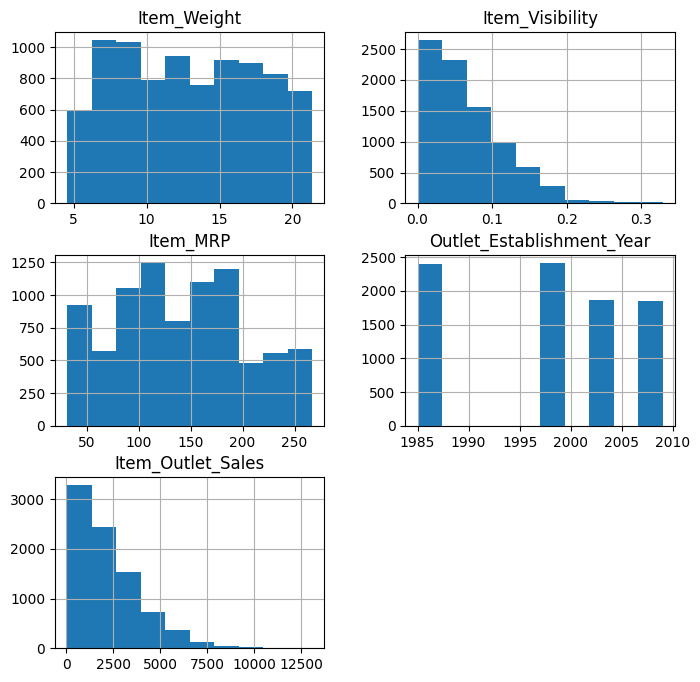

In [ ]:
#Distributions of numerical columns
df_sales.hist(figsize=(8,8))

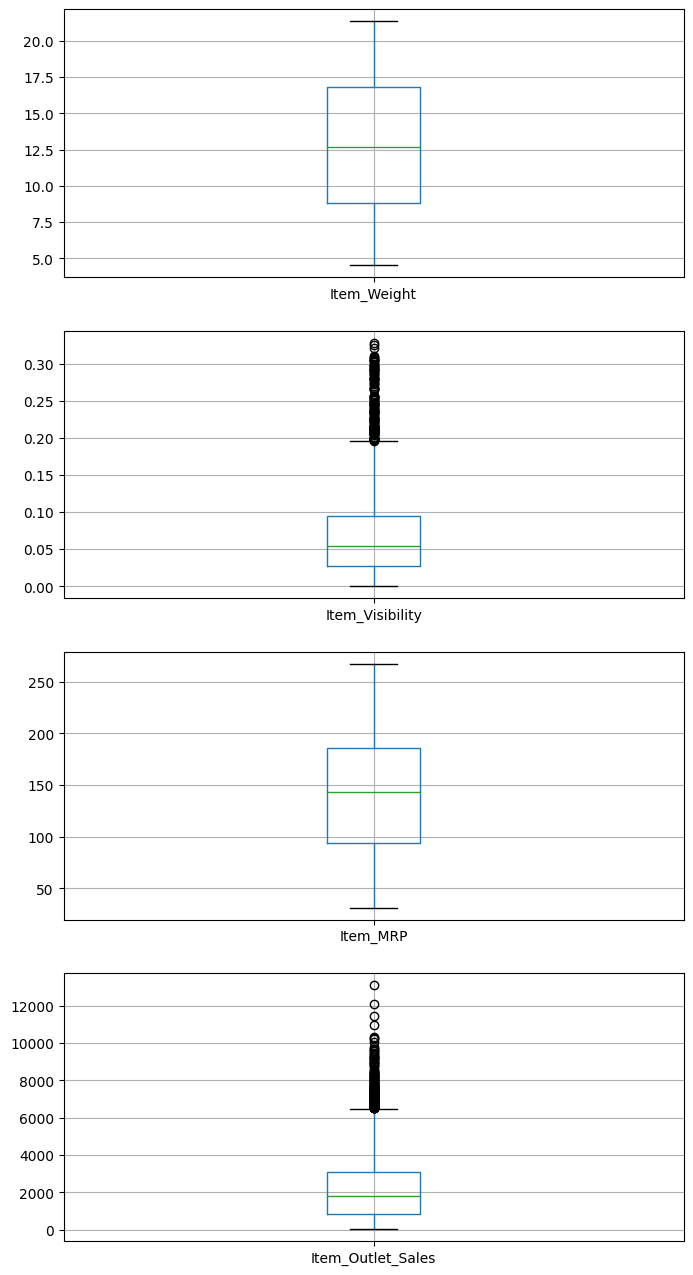

In [ ]:
plt.figure(figsize=(8,16))
num_list = df_sales.select_dtypes("float").columns
for i in range(len(num_list)) :
      plt.subplot(len(num_list),1,i+1)
      df_sales[[num_list[i]]].boxplot()

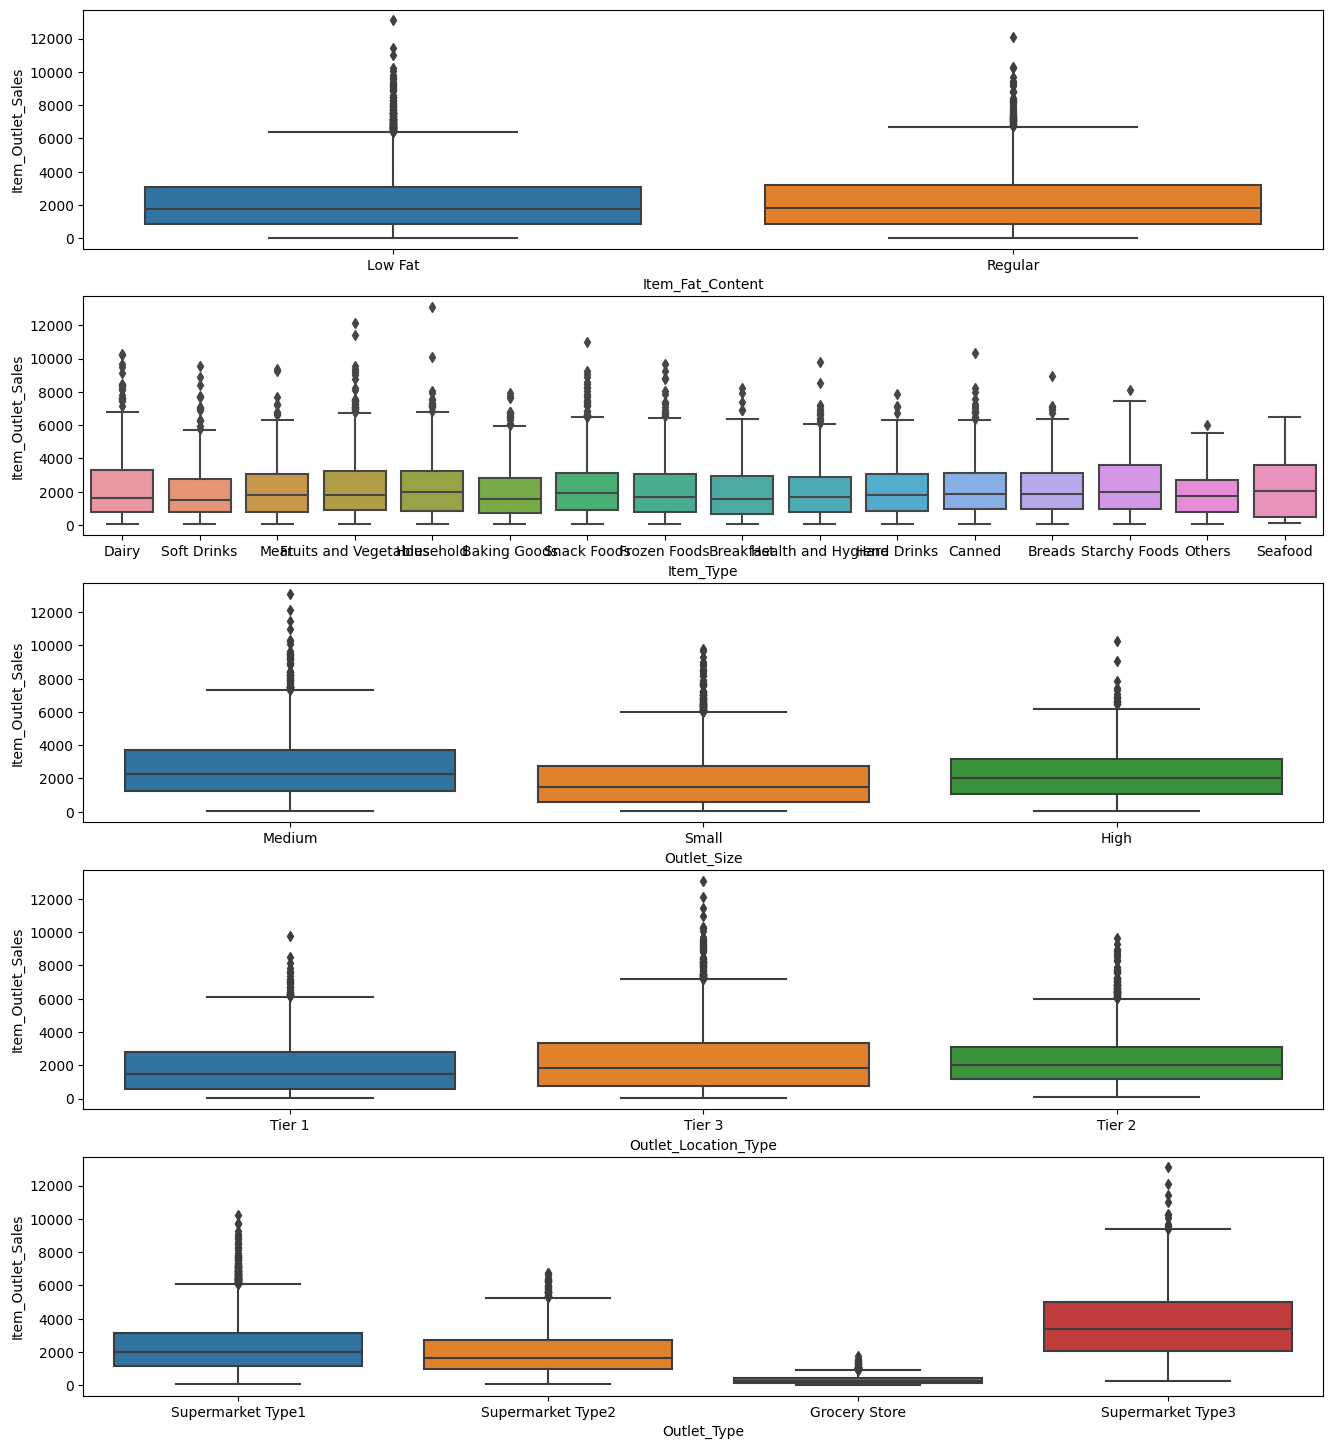

In [ ]:
plt.figure(figsize=(16,18))
cat_list = ["Item_Fat_Content","Item_Type","Outlet_Size","Outlet_Location_Type","Outlet_Type"]
for i in range(len(cat_list)) :
      plt.subplot(len(cat_list),1,i+1)
      sns.boxplot(data=df_sales,x=cat_list[i],y="Item_Outlet_Sales")

<Axes: xlabel='Item_Type', ylabel='Item_Visibility'>

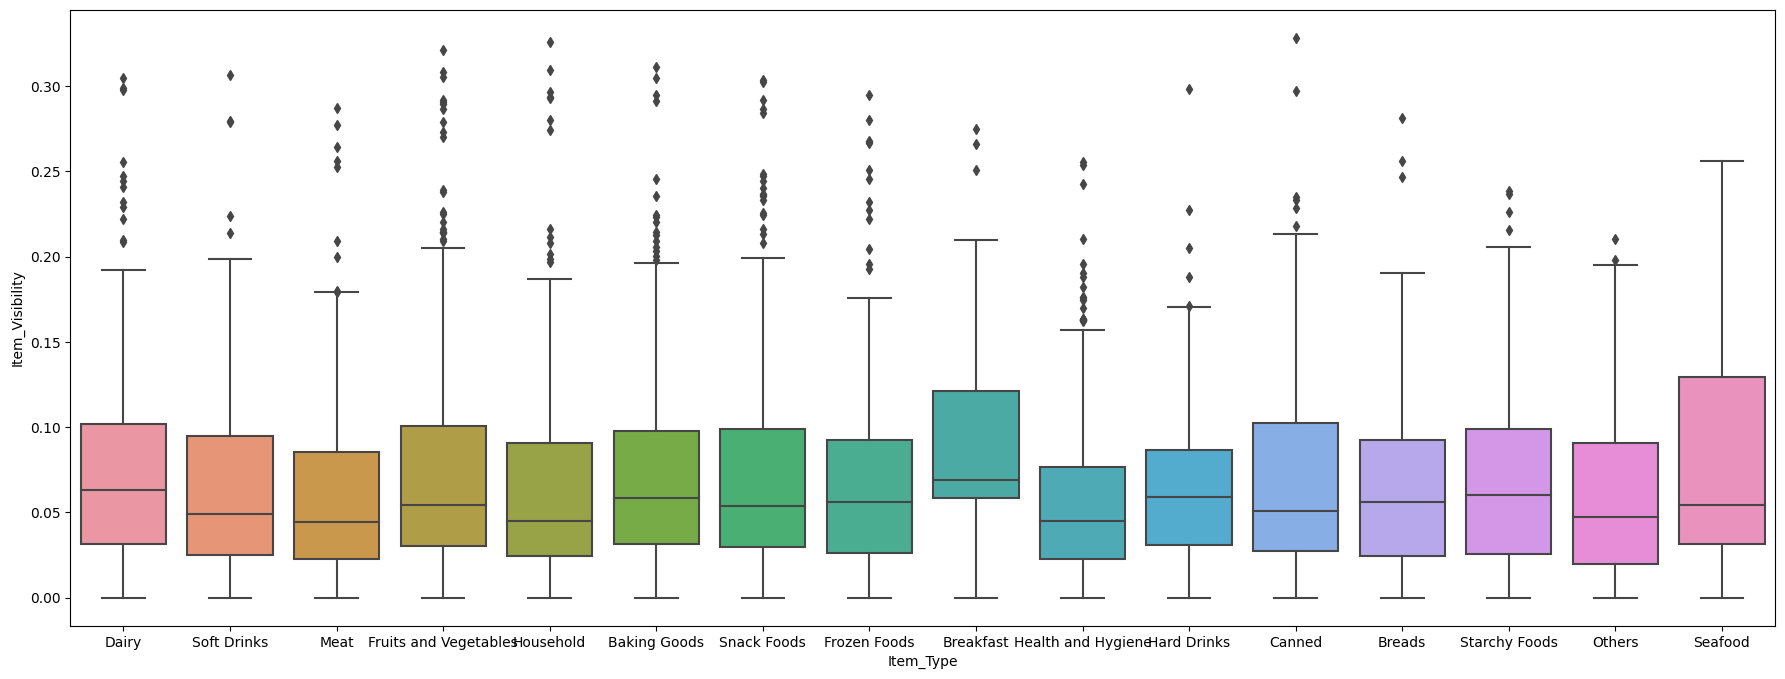

In [ ]:
plt.figure(figsize=(22,8))
sns.boxplot(data=df_sales,x="Item_Type",y="Item_Visibility")

<ipython-input-25-25cad4bd2285>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_sales.corr(),annot=True,cmap="rocket_r")


<Axes: >

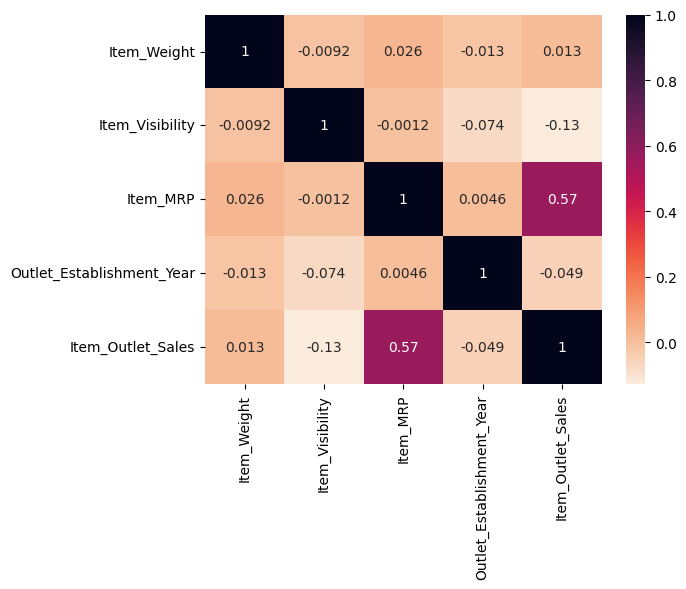

In [ ]:
sns.heatmap(df_sales.corr(),annot=True,cmap="rocket_r")

# Data Explanation

<Axes: title={'center': 'Sales VS Item Type'}, xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

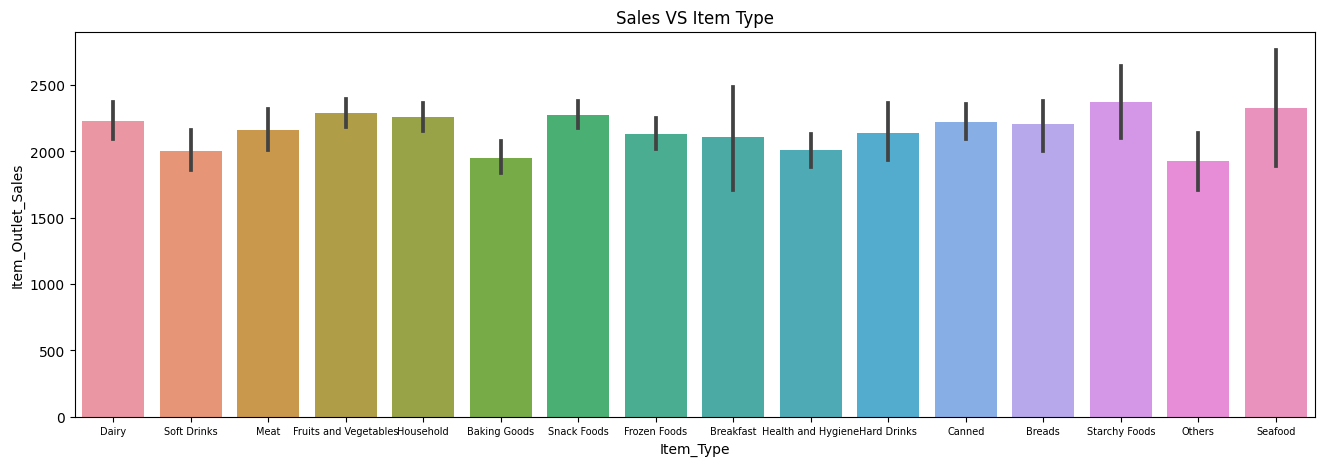

In [ ]:
plt.figure(figsize=(16,5))
plt.title("Sales VS Item Type")
plt.xticks(fontsize=7)
sns.barplot(data=df_sales,y="Item_Outlet_Sales",x="Item_Type")

We notice that the item type has not a significant impact on the sales

Text(0.5, 1.0, 'Relationship between item sales in a specific outlet and Item MRP classified by the outlet type')

<Figure size 2000x1000 with 0 Axes>

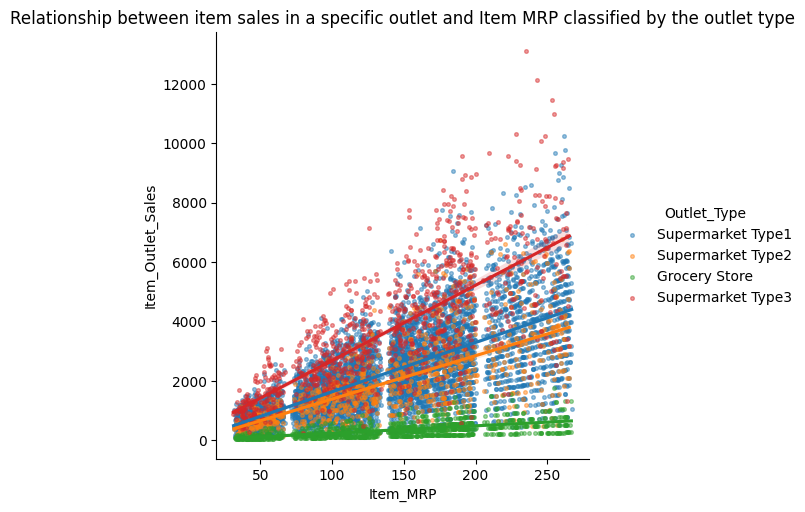

In [ ]:
plt.figure(figsize=(20,10))
sns.lmplot(data=df_sales,x="Item_MRP",y="Item_Outlet_Sales",hue="Outlet_Type",scatter_kws={"alpha":0.45,"s":7})
plt.title("Relationship between item sales in a specific outlet and Item MRP classified by the outlet type")

We see that The item MRP and sales are almost linearly correlated for each outlet type.

# Data Preprocessing

In [ ]:
df_sales = pd.read_csv(f"https://docs.google.com/uc?id={file_id}")

In [ ]:
#fixing inconsistent categories of data
df_sales.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'},inplace=True)

In [ ]:
#defining features and target
X = df_sales.iloc[:,:-1].drop(columns=["Item_Identifier","Outlet_Identifier"])
y = df_sales.Item_Outlet_Sales

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
#splitting dataset to train data and test data
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [ ]:
#defining numerical features
num_cols = X.select_dtypes("float").columns
#defining categorical features
cat_cols = ["Item_Type","Outlet_Location_Type","Outlet_Type"]
#defining ordinal features
ord_cols = ["Item_Fat_Content","Outlet_Size","Outlet_Establishment_Year"]

In [ ]:
#changing tranformers outputs to pandas dataframes
from sklearn import set_config
set_config(transform_output = "pandas")

In [ ]:
#Defining transforms
ohe = OneHotEncoder(sparse_output=False)
ord_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OrdinalEncoder())
num_pipeline = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())

In [ ]:
num_tuple = ("Numerical",num_pipeline,num_cols)
cat_tuple = ("categorical",ohe,cat_cols)
ord_tuple = ("ordinal",ord_pipeline,ord_cols)

In [ ]:
#defining a transormer for categorical and ordinal
cols_transformer = ColumnTransformer([num_tuple,cat_tuple,ord_tuple],verbose_feature_names_out=False)

In [ ]:
#fitting columns transformer
cols_transformer.fit(x_train)

ColumnTransformer(transformers=[('Numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('categorical',
                                 OneHotEncoder(sparse_output=False),
                                 ['Item_Type', 'Outlet_Location_Type',
                                  'Outlet_Type']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Item_Fat_Content', 'Outlet_Size',
                                  'Outlet_Establishment_Year'])],
                  verbose_feature_names_out=False)

In [ ]:
#transforming columns
x_train_tr = cols_transformer.transform(x_train)
x_test_tr = cols_transformer.transform(x_test)

In [ ]:
x_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5966 entries, 1921 to 7270
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      5966 non-null   float64
 1   Item_Visibility                  5966 non-null   float64
 2   Item_MRP                         5966 non-null   float64
 3   Item_Type_Baking Goods           5966 non-null   float64
 4   Item_Type_Breads                 5966 non-null   float64
 5   Item_Type_Breakfast              5966 non-null   float64
 6   Item_Type_Canned                 5966 non-null   float64
 7   Item_Type_Dairy                  5966 non-null   float64
 8   Item_Type_Frozen Foods           5966 non-null   float64
 9   Item_Type_Fruits and Vegetables  5966 non-null   float64
 10  Item_Type_Hard Drinks            5966 non-null   float64
 11  Item_Type_Health and Hygiene     5966 non-null   float64
 12  Item_Type_Househo

In [ ]:
x_train_tr[num_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP
count,5966.00,5966.00,5966.00
mean,0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-1.99,-1.29,-1.76
25%,-0.82,-0.76,-0.76
50%,0.00,-0.23,0.03
75%,0.75,0.56,0.72
max,2.00,5.14,2.00


In [ ]:
x_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 7503 to 3742
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      2557 non-null   float64
 1   Item_Visibility                  2557 non-null   float64
 2   Item_MRP                         2557 non-null   float64
 3   Item_Type_Baking Goods           2557 non-null   float64
 4   Item_Type_Breads                 2557 non-null   float64
 5   Item_Type_Breakfast              2557 non-null   float64
 6   Item_Type_Canned                 2557 non-null   float64
 7   Item_Type_Dairy                  2557 non-null   float64
 8   Item_Type_Frozen Foods           2557 non-null   float64
 9   Item_Type_Fruits and Vegetables  2557 non-null   float64
 10  Item_Type_Hard Drinks            2557 non-null   float64
 11  Item_Type_Health and Hygiene     2557 non-null   float64
 12  Item_Type_Househo

# Modeling

In [ ]:
# Make linear regressor
lin_reg = LinearRegression()
lin_pipeline = make_pipeline(cols_transformer,lin_reg)
lin_pipeline.fit(x_train, y_train)
y_train_pred = lin_pipeline.predict(x_train)
y_test_pred = lin_pipeline.predict(x_test)
tab = tabulate([["Metric","Training Set","Testing Set"],
                ["r2",r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)],
                ["RMSE",mean_squared_error(y_train,y_train_pred,squared=False),mean_squared_error(y_test,y_test_pred,squared=False)]],
               headers='firstrow',numalign="left")
print(tab)

Metric    Training Set    Testing Set
--------  --------------  -------------
r2        0.560077        0.567277
RMSE      1140.63         1100.93


According to r2 score the linear ragressor is better than the mean model.The RMSE score on the train set is almost equal to the test set one so the linear ragressor dont overfit the training data

In [ ]:
# Make decision tree regressor
tree_reg = DecisionTreeRegressor(max_depth=5,random_state=42)
tree_pipeline = make_pipeline(cols_transformer,tree_reg)
tree_pipeline.fit(x_train, y_train)
y_train_pred = tree_pipeline.predict(x_train)
y_test_pred = tree_pipeline.predict(x_test)
tab = tabulate([["Metric","Training Set","Testing Set"],
                ["r2",r2_score(y_train,y_train_pred),r2_score(y_test,y_test_pred)],
                ["RMSE",mean_squared_error(y_train,y_train_pred,squared=False),mean_squared_error(y_test,y_test_pred,squared=False)]],
               headers='firstrow',numalign="left")
print(tab)

Metric    Training Set    Testing Set
--------  --------------  -------------
r2        0.604615        0.597148
RMSE      1081.35         1062.25


According to r2 and RMSE metrics on the test set, decision tree regressor is better than the the the linear regressor.

I recommend the decision tree regressor as it has low variance and performs better on the test data.